### This experiment compares stats of relaiton between physical session and tasks presented in Jones et al., Lucchess et al., and Hagen et al.

#### Results reported in the paper: Section 4.2.2

#### Important details:
- All events where users were not "on" are filtered out in the first pass, all the rest works on the cleaned log.
- For physical sessions, "None" tasks were removed before segementing the log, this may reduces task changes. The general trend does not change, and the task detection would be improved to match the literature (which also does many filtering steps).
- For logical session, we set 90 minutes "user leave" threshold. This may change the performance of physical session. Performance of threhold beyond 90 minutes would be influenced. 

# Setup

In [349]:
%matplotlib inline
import pymongo
from pymongo import MongoClient
import numpy as np
import itertools
import urllib
import sys
sys.path.append('../variables/')
import UserActivity
import matplotlib
import matplotlib.pylab as pylab
from bson.objectid import ObjectId
from scipy.stats import gaussian_kde, ks_2samp

outputdir = 'plots/'

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2

# DB connections
client = MongoClient()
db = client.db_tasklog_clean
# Collections
User = db.user
Log = db.log_chrome
Labelled = db.data_labeled
UserTasks = db.user_tasks

# Tasks to be excluded
to_exclude = ['000', '001', '002', '003', '004']
# Pre-defined labels - excluding "not sure (001)"
pre_tasks = ['001', '002', '003', '004']
# new query 
query_events = ['tab-search-new', 'tab-search-verticle'] 
# Get user task activities
# Set dummy parameters
t_thresh = -1 # Look at first X minutes, not used
session_thresh = 30 # in minutes, threshold to consider users have left without closing the tab, not used
to_include = [] # Not used for this computation 

## Function to get all events for a user

In [350]:
# All events
def event_stream(data):
    events = []
    # data consists of tab-groups
    for s in data:
        tab_group = s['tab_group']
        tabid = s['tabid']
        # tab groups consist of url groups
        for ug in tab_group:
            # a group of events sharing the same url
            url_group = ug['url_group']
            for e in url_group:
                events.append(e)
    events.sort(key=lambda x: x['timestamp_bson'])
    return events

## Prepare user activity data for analysis

### Return:
* Stream of user events: {userid, [(event, user_on), (event, user_on)...]}
* Filter out events where users were not "on" the page

In [351]:
# Gether user activity data for analysis
UA = []
users = list(User.find({}))
for u in users:
    userid = u['userid']
    data = list(Labelled.find({'userid': u['userid']}))[0]['data']
    events = event_stream(data)
    ua = UserActivity.UserActivity(data, to_include, t_thresh, session_thresh)
    a_path, a_stream = ua.get_user_path()
    
    # filter out events where user was not on the tab
    user_stream = list(itertools.ifilter(lambda x: x[1] == True, a_stream))
    UA.append((userid, user_stream))

## Functions to filter event or task types

In [352]:
# Data format: stream of events
# All tasks except those are labelled as "None"
def filter_tasks(data):
    return list(itertools.ifilter(lambda x: not x[0]['taskid'] == 'None', data))

def filter_user_tasks(data):
    return list(itertools.ifilter(lambda x: not x[0]['taskid'] in (['None'] + to_exclude), data))

def filter_predefined_tasks(data):
    return list(itertools.ifilter(lambda x: x[0]['taskid'] in pre_tasks, data))

def filter_query_events(data):
    return list(itertools.ifilter(lambda x: x[0]['event'] in query_events, data))

## Function to compute time gap between events

In [353]:
# Data format: stream of events
# It still contains the "on" value, but we don't use it, as the data is already filtered on events where users are on
def time_gap(data):
    start = -1
    i = 0
    for event, on in data:
        event['dwell'] = -1
        if start == -1:
            start = event['timestamp_bson']
            continue
        gap = (event['timestamp_bson'] - start).total_seconds()/60
        data[i][0]['dwell'] = gap
        start = event['timestamp_bson']
        i += 1
    return data

## Function to create physical and logical sessions

In [354]:
# Data format: stream of events
# Data should have already been filtered to only include event where the user is "on"

# Create physical sessions based on time-gap between events:
def physical_session(data, thresh):
    P = []
    s = []
    prev = -1
    idx = 0
    for event, on in data:
        if prev == -1:
            prev = event
            s.append((event, idx))
            continue
        gap = (event['timestamp_bson'] - prev['timestamp_bson']).total_seconds()/60
        if gap > thresh:
            P.append(s)
            s = []
        prev = event
        s.append((event, idx))
        idx += 1
    P.append(s)
    return P

In [355]:
# Data format: stream of events
# Data should have already been filtered to only include event where the user is "on"

# Criteria for logical session:
# 1. consecutive events belong to the same task
# 2. a pause longer than 90 mins makes a session break (user may have left)
def logical_session(data):
    L = []
    s = []
    prev = -1
    idx = 0
    for event, on in data:
        if prev == -1:
            prev = event
            s.append((event, idx))
            continue
        gap = (event['timestamp_bson'] - prev['timestamp_bson']).total_seconds()/60
        # Keep adding to the logical session if conditions are satisfied
        if prev['taskid'] == event['taskid'] and gap < 90:
            s.append((event, idx))
        # Otherwise, start a new session
        else:
            slength = (s[-1][0]['timestamp_bson'] - s[0][0]['timestamp_bson']).total_seconds()
            # Filter out sessions that last 0 seconds
            if not s == [] and slength > 0:
                L.append(s)
            s = []
            s.append((event, idx))
        prev = event
        idx += 1
    # Add the last session
    slength = (s[-1][0]['timestamp_bson'] - s[0][0]['timestamp_bson']).total_seconds()
    if not s == [] and slength > 0:
        L.append(s)
    return L

## Functions to compute number of queries, time span in a session

In [356]:
# Input data should be a stream of events
def number_queries(session):
    return sum([int(s['event'] in query_events) for s in session])

def time_span(session):
    return (session[-1]['timestamp_bson']-session[0]['timestamp_bson']).total_seconds()/60
    

## Function to make density plot

In [357]:
def density_plot(data, X, marker, hold=True):
    if hold == False:
        pylab.figure()
        
    ax = pylab.subplot()
    kde = gaussian_kde(data)
    # Make log of the X data
    Y = kde.evaluate(X) 
    ax.plot(X, Y, marker)
    
def log_density_plot(data, X, marker, xticklabels, hold=True):
    if hold == False:
        pylab.figure()
    ax = pylab.subplot()
    kde = gaussian_kde(data)
    # Make log of the X data
    X = [np.log(x) if x > 0 else 0 for x in X]
    Y = kde.evaluate(X)

    ax.plot(X, Y, marker)
    # Make the X label to show the original scale
    xticks = [np.log(x) if x > 0 else 0 for x in xticklabels]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    current_ylim = ax.get_ylim()
    ax.set_ylim([0, max(max(Y), current_ylim[1])+0.01])

## Phycial session and tasks

1. threshold vs. task boundary (cf. Jones)
 - only look at query
 - look at query and other events
2. Different events have different distribution of dwell time
 
### Note:
* Data used for this experiment filtered out events that are labelled as "None" tasks

Best Precision:  0.761194029851 (thresh:61) ; Q based eval: 0.761194029851 (thresh:61)
Best Recall: 0.0185185185185 (thresh:1) ; Q based eval: 0.826086956522 (thresh:1)
Best F1: 0.0353943077848 (thresh:1) ; Q based eval: 0.598922584703 (thresh:5)


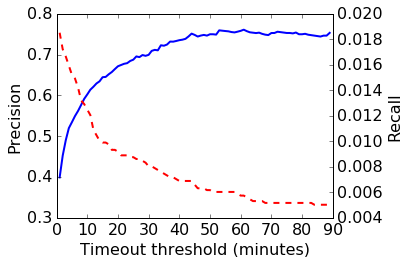

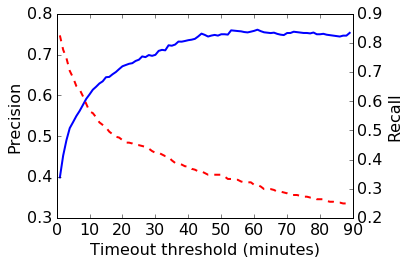

In [358]:
# Evaluate the precision and recall of task boundaries
# gt is in practice the logical sessions
def eval_boundary(sessions, gt):
    # Boundaries represented by the index of the last element of each segments
    B = [(gt[i][-1][1], gt[i][-1][0]['taskid'], gt[i+1][0][0]['taskid']) for i in range(len(gt)-1)]
    # Session boundaries

    S = [s[-1][1] for s in sessions]
    # Precision
    # Check if before and after the query, taskid has changed
    TP_prec = 0
    TP_recall = 0
    prev = sessions[0]
    for s in sessions[1:]:
        # Precision: Compare taskids before and after the splitting point
        prev_task = prev[-1][0]['taskid']
        current_task = s[0][0]['taskid']
        if not prev_task == current_task:
            TP_prec += 1
            # Recall: check if between the boundary of queries there is only one switch of tasks, then it's a hit
            prev_id = prev[-1][1]
            current_id = s[0][1]
            switches = list(itertools.ifilter(lambda x: x[0]<=current_id and x[0]>=prev_id, B))
            if len(switches) == 1:
                TP_recall += 1
        prev = s
    return TP_prec, TP_recall
    
def threshold_vs_tasks():
    TP_p, qTP_p = {}, {}
    TP_r, qTP_r = {}, {}
    tot_P, qtot_P = {}, {}
    tot_R, qtot_R = {}, {}
    for userid, ua in UA:
        # Filter out None tasks
        data = list(itertools.ifilter(lambda x: not x[0]['taskid'] == 'None', ua))
        # Get logical sessions which provides boundaries of tasks
        l_sessions = logical_session(data)
        # Get query based logical sessions
        data_q = list(itertools.ifilter(lambda x: x[0]['event'] in query_events, data))
        l_sessions_q = logical_session(data_q)
        # Loop over different thresholds for physical sessions
        for thresh in range(1, 90):
            # Get physical sessions based on query gaps
            #q_sessions = physical_session_query(data, thresh)
            q_sessions = physical_session(data_q, thresh)
            # Evaluation using event based GT
            TP_prec, TP_recall = eval_boundary(q_sessions, l_sessions)
            # Evaluation using query based GT
            qTP_prec, qTP_recall = eval_boundary(q_sessions, l_sessions_q)
            
            TP_p[thresh] = TP_p.get(thresh, 0) + TP_prec
            TP_r[thresh] = TP_r.get(thresh, 0) + TP_recall
            tot_P[thresh] = tot_P.get(thresh, 0) + len(q_sessions) - 1
            tot_R[thresh] = tot_R.get(thresh, 0) + len(l_sessions) - 1

            qTP_p[thresh] = qTP_p.get(thresh, 0) + qTP_prec
            qTP_r[thresh] = qTP_r.get(thresh, 0) + qTP_recall
            qtot_P[thresh] = qtot_P.get(thresh, 0) + len(q_sessions) - 1
            qtot_R[thresh] = qtot_R.get(thresh, 0) + len(l_sessions_q) - 1

    X = range(1, 90)
    # Event based evaluation
    P = [TP_p[x]/float(tot_P[x]) for x in X]
    R = [TP_r[x]/float(tot_R[x]) for x in X]
    
    # Query based evaluation
    qP = [qTP_p[x]/float(qtot_P[x]) for x in X]
    qR = [qTP_r[x]/float(qtot_R[x]) for x in X]
    
    fig, ax1 = pylab.subplots()
    ax1.plot(X, P, 'b-', label="Precision")
    ax1.set_ylabel('Precision')
    ax1.set_xlabel('Timeout threshold (minutes)')
    ax1.set_ylim([0.3, 0.8])
    # qP = P, only recall would change
    
    ax2 = ax1.twinx()    
    ax2.plot(X, R, 'r--', label="Recall")
    ax2.set_ylabel('Recall')
    
    
    figure = '%s/timeout_query_event.eps'%outputdir
    pylab.tight_layout()
    pylab.savefig(figure)
    
    pylab.figure()
    fig, ax1 = pylab.subplots()
    ax1.plot(X, qP, 'b-', label="Precision")
    ax1.set_ylabel('Precision')
    ax1.set_xlabel('Timeout threshold (minutes)')
    # qP = P, only recall would change
    
    ax2 = ax1.twinx()    
    ax2.plot(X, qR, 'r--', label="Recall")
    ax2.set_ylabel('Recall')

    ax1.set_ylim([0.3, 0.8])
    figure = '%s/timeout_query_query.eps'%outputdir
    pylab.tight_layout()
    pylab.savefig(figure)

    
    # Some stats
    P.index(max(P))
    
    print 'Best Precision: ', max(P), "(thresh:%s)"%X[P.index(max(P))], 
    print '; Q based eval:', max(qP), "(thresh:%s)"%X[qP.index(max(qP))]
    print 'Best Recall:', max(R), "(thresh:%s)"%X[R.index(max(R))],
    print '; Q based eval:', max(qR), 
    print "(thresh:%s)"%X[qR.index(max(qR))]
    
    F = [P[i]*R[i]*2/(P[i] + R[i]) for i in range(len(P))]
    qF = [qP[i]*qR[i]*2/(qP[i] + qR[i]) for i in range(len(qP))]
    print "Best F1:", max(F), "(thresh:%s)"%X[F.index(max(F))],
    print '; Q based eval:', max(qF), "(thresh:%s)"%X[qF.index(max(qF))]
    
#Precision, recall given different threshold
threshold_vs_tasks()

Best Precision:  0.680327868852 (thresh:89)
Best Recall: 0.181309216193 (thresh:1)
Best F1: 0.248421775056 (thresh:1)


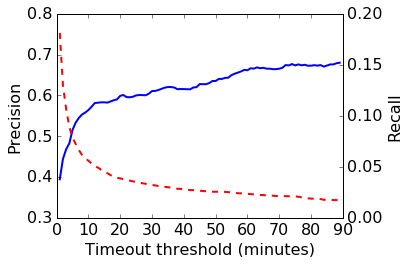

In [359]:
# Instead of thresholding on queries, try events
def threshold_vs_tasks_events():
    TP_p = {}
    TP_r = {}
    tot_P = {}
    tot_R = {}
    for userid, ua in UA:
        # Filter out None tasks
        data = list(itertools.ifilter(lambda x: not x[0]['taskid'] == 'None', ua))
        #data = ua
        # Get logical sessions which provides boundaries of tasks
        l_sessions = logical_session(data)
        for thresh in range(1, 90):
            # Get physical sessions based on query gaps
            sessions = physical_session(data, thresh)
            TP_prec, TP_recall = eval_boundary(sessions, l_sessions)
            TP_p[thresh] = TP_p.get(thresh, 0) + TP_prec
            TP_r[thresh] = TP_r.get(thresh, 0) + TP_recall
            tot_P[thresh] = tot_P.get(thresh, 0) + len(sessions) - 1
            tot_R[thresh] = tot_R.get(thresh, 0) + len(l_sessions) - 1


    X = range(1, 90)
    P = [TP_p[x]/float(tot_P[x]) for x in X]
    R = [TP_r[x]/float(tot_R[x]) for x in X]
    
    fig, ax1 = pylab.subplots()
    ax1.plot(X, P, 'b-', label="Precision")
    ax1.set_ylabel('Precision')
    ax1.set_ylim([0.3, 0.8])
    ax1.set_xlabel('Timeout threshold (minutes)')
    
    ax2 = ax1.twinx()    
    ax2.plot(X, R, 'r--', label="Recall")
    ax2.set_ylabel('Recall')
    
    figure = '%s/timeout_event_event.eps'%outputdir
    pylab.tight_layout()
    pylab.savefig(figure)
    
    # Some stats
    print 'Best Precision: ', max(P), "(thresh:%s)"%X[P.index(max(P))]
    print 'Best Recall:', max(R), "(thresh:%s)"%X[R.index(max(R))]
    F = [P[i]*R[i]*2/(P[i] + R[i]) for i in range(len(P))]
    print "Best F1:", max(F), "(thresh:%s)"%X[F.index(max(F))]
    
#Precision, recall given different threshold
threshold_vs_tasks_events()

1 form_submit H:97 (0.0215) T:158 (0.0350) M:4257 (0.9435) Total:  4512
2 forward/backward H:57 (0.0769) T:3 (0.0040) M:681 (0.9190) Total:  741
3 link_click H:899 (0.0428) T:1193 (0.0567) M:18932 (0.9005) Total:  21024
4 pagination H:0 (0.0000) T:0 (0.0000) M:45 (1.0000) Total:  45
5 query H:743 (0.2378) T:16 (0.0051) M:2366 (0.7571) Total:  3125
6 tab_close H:911 (0.2521) T:835 (0.2310) M:1868 (0.5169) Total:  3614
7 tab_new H:316 (0.3309) T:2 (0.0021) M:637 (0.6670) Total:  955
8 tab_switch H:2741 (0.2954) T:1215 (0.1309) M:5323 (0.5737) Total:  9279
9 type_in_url H:678 (0.6092) T:19 (0.0171) M:416 (0.3738) Total:  1113


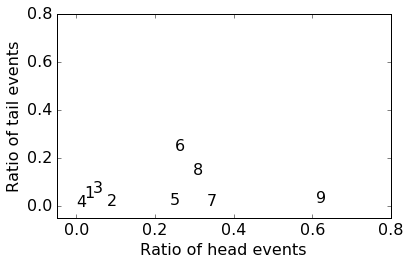

In [360]:
# Merge events into a few categories:
# The merge is based on: how the event were generated, and they generally have similar HTM ratios
# - query
# - link_click
# - form_submit
# - forward_back
# - go_to_url
# - pagination
# - tab_new
# - tab_close
# - tab_switch
# - tab_loading
# The two events that don't have a category: tab-search-noquery navigation-manual_subframe
def get_event_category(event):
    #These event usually will follow/followed by tab-search event
    if event in query_events + ['navigation-keyword', "navigation-omni_query", "tab-replace-switch"]:
        return "query"
    elif "link" in event:
        return "link_click"
    elif "form_submit" in event:
        return "form_submit"
    elif 'forward_back' in event or "backward" in event:
        return "forward/backward"
    elif event == "navigation-omni_url":
        return "type_in_url"
    elif event == 'tab-search-pagination':
        return "pagination"
    # they all relate to start a new tab
    elif event in ['navigation-start_page', 'tab-open-in-new', 'tab-new-switch']:
        return "tab_new"
    elif event in ['tab-close', 'tab-close-switch']:
        return "tab_close"
    elif event in ['tab-loaded', 'tab-loaded-SERP', 'navigation-reload']:
        return "tab_load"
    elif event in ['tab-switch']:
        return 'tab_switch'
    else:
        return "?"

# Check which events are usually task breakers
def task_breakers(data, H, T, M):
    # Count of events being head, tail of logical sessions
    sessions = logical_session(data)
    for s in sessions:
        head = get_event_category(s[0][0]['event'])
        tail = get_event_category(s[-1][0]['event'])
        H[head] = H.get(head, 0) + 1
        T[tail] = T.get(tail, 0) + 1
        M_events = [get_event_category(x[0]['event']) for x in s[1:-2]]
        M_events.sort()
        for k, g in itertools.groupby(M_events):
            M[k] = M.get(k, 0) + len(list(g))


# Look at distribution of stats over different types of events
def event_distribution():
    all_events = set([])
    H, T, M = {}, {}, {}
    G = []
    for userid, ua in UA:
        # Filter out "None" tasks
        data = list(itertools.ifilter(lambda x: not x[0]['taskid'] == 'None', ua))
        # Get dwell time
        data_with_gap = time_gap(ua)
        #print len(data)
        #gaps = [(e, e['dwell']) for e, on in data if e['dwell'] >= 0]
        all_events = all_events.union(set(list([get_event_category(d[0]['event']) for d in data])))
        task_breakers(data, H, T, M)


    #for e in all_events:
    #    print e, get_event_category(e)
    #print
        
    # Make plot
    # print "Events Head, Tail, Middle counts:"
    pylab.figure()
    i = 0
    for e in sorted(all_events):
        # Tab loaded is not a user event, skip it
        # Triggers of tab-loadings have been recorded already
        if e == '?' or e == 'tab_load':
            continue
        i += 1
        h = H.get(e, 0)
        t = T.get(e, 0)
        m = M.get(e, 0)
        tot = h + t + m
        print i, e, "H:%s (%.4f)"%(h, float(h)/tot), "T:%s (%.4f)"%(t, float(t)/tot), 
        print "M:%s (%.4f)"%(m, float(m)/tot), "Total: ", tot
        # Filter out events that occur less than 10 times

        pylab.text(float(h)/tot, float(t)/tot, i, label=e)
        
    pylab.xlabel('Ratio of head events')
    pylab.ylabel('Ratio of tail events')
    pylab.xlim([-0.05, 0.8])
    pylab.ylim([-0.05, 0.8])
    ticks = [0, 0.2, 0.4, 0.6, 0.8]
    pylab.xticks(ticks)
    pylab.yticks(ticks)
    pylab.tight_layout()
    figure = '%s/event_head_tail.eps'%outputdir
    pylab.savefig(figure)
    
event_distribution()
